In [5]:
import keras_tuner as kt
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import shap
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
####################################################### load dataframe
# Load dataset from ppi.csv
df = pd.read_csv("ppi.csv")

print(df.columns)

Index(['Unnamed: 0', 'domain', 'aa_ProtPosition', 'uniprot_id', 'Rlength',
       'sequence', 'normalized_length', 'normalized_abs_surf_acc',
       'normalized_hydropathy_index', 'rel_surf_acc',
       ...
       '9_wm_pssm_K', '9_wm_pssm_M', '9_wm_pssm_F', '9_wm_pssm_P',
       '9_wm_pssm_S', '9_wm_pssm_T', '9_wm_pssm_W', '9_wm_pssm_Y',
       '9_wm_pssm_V', 'p_interface'],
      dtype='object', length=138)


In [7]:
####################################################### fix sequence in DF
# Define the set of standard amino acids
standard_aas = set("ACDEFGHIKLMNPQRSTVWY")

# detect non-standard amino acids in a sequence (here, each sequence is a single letter)
def has_non_standard(seq):
    return seq not in standard_aas

# identify rows where sequence contains a non-standard amino acid
non_standard_mask = df["sequence"].apply(has_non_standard)

if non_standard_mask.any():
    print("Found non-standard amino acids in the following rows:")
    print(df.loc[non_standard_mask, ["uniprot_id", "sequence"]])
    # Remove rows with non-standard amino acids
    df = df.loc[~non_standard_mask].copy()
else:
    print("All sequences contain standard amino acids.")
    

seq_dummies = pd.get_dummies(df["sequence"], prefix="aa")

# Ensure that we have columns for all 20 standard amino acids (in case some letters are missing in the data)
aa_order = "ACDEFGHIKLMNPQRSTVWY"
expected_cols = [f"aa_{aa}" for aa in aa_order]
seq_dummies = seq_dummies.reindex(columns=expected_cols, fill_value=0)

# Drop the original sequence column and concatenate the one-hot encoded columns
df = df.drop(columns=["sequence"])
df = pd.concat([df, seq_dummies], axis=1)



Found non-standard amino acids in the following rows:
      uniprot_id sequence
29636     Q01786        X



Class Distribution:
p_interface
0    57304
1     7845
Name: count, dtype: int64


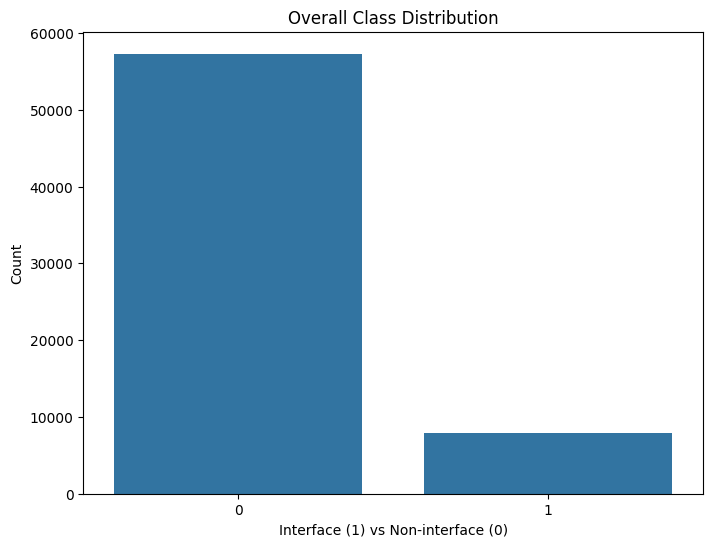

In [8]:
######################################################## check overall class distrubution
# Check overall class distribution for the target
target = "p_interface"
class_counts = df[target].value_counts()
print("\nClass Distribution:")
print(class_counts)

# Visualize the overall class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=df)
plt.title("Overall Class Distribution")
plt.xlabel("Interface (1) vs Non-interface (0)")
plt.ylabel("Count")
plt.show()

In [9]:
########################################################## make train, validation and test split
# Count the number of unique proteins based on uniprot_id
unique_proteins = df['uniprot_id'].nunique()
print("\nNumber of Unique Proteins (uniprot_id):", unique_proteins)

# Explore the class distribution per protein
protein_class_distribution = df.groupby('uniprot_id')[target].value_counts().unstack().fillna(0)
print("\nProtein-wise Class Distribution (first 5 proteins):")
print(protein_class_distribution.head())

# Define target and keep uniprot_id for splitting (we'll drop it later)
target = "p_interface"

# Get unique uniprot_ids to use as groups
unique_groups = df['uniprot_id'].unique()

# First split: 80% train and 20% temporary (which will be split into validation and test)
train_groups, temp_groups= train_test_split(unique_groups, test_size=0.2, random_state=22)

# Second split: Split the temporary groups into validation and test equally (10% each)
val_groups, test_groups = train_test_split(temp_groups, test_size=0.5, random_state=42)

# Create the train, validation, and test dataframes by filtering on uniprot_id groups
train_df = df[df['uniprot_id'].isin(train_groups)]
val_df   = df[df['uniprot_id'].isin(val_groups)]
test_df  = df[df['uniprot_id'].isin(test_groups)]

########
train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
val_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
test_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])

# Define features and target for each split.
# Drop the columns "uniprot_id", "domain", etc.
X_train = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
y_train = train_df[target]

X_val = val_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_val = val_df[target]

X_test = test_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_test = test_df[target]


Number of Unique Proteins (uniprot_id): 228

Protein-wise Class Distribution (first 5 proteins):
p_interface    0   1
uniprot_id          
A0A010       185  75
A0A024RAV5   175  13
A0A0D5YE19   290  26
A0A0F4FI39   324  10
A0A0H2VDD2   199   8


In [10]:
####################################### calcualte class weight of train on the validation
class_weights = compute_class_weight("balanced", classes=np.unique(y_val), y=y_val)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_val), class_weights)}
print(class_weights)

{np.int64(0): np.float64(0.575627174510163), np.int64(1): np.float64(3.805690072639225)}


In [11]:
######################################### check overlap

# Check that the splits have disjoint uniprot_ids
train_ids = set(train_df['uniprot_id'])
val_ids   = set(val_df['uniprot_id'])
test_ids  = set(test_df['uniprot_id'])

print("Overlap between Train & Validation:", train_ids.intersection(val_ids))
print("Overlap between Train & Test:", train_ids.intersection(test_ids))
print("Overlap between Validation & Test:", val_ids.intersection(test_ids))

print("Unique uniprot_ids in Train:", train_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Validation:", val_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Test:", test_df["uniprot_id"].nunique())

Overlap between Train & Validation: set()
Overlap between Train & Test: set()
Overlap between Validation & Test: set()
Unique uniprot_ids in Train: 182
Unique uniprot_ids in Validation: 23
Unique uniprot_ids in Test: 23



Class Distribution:
Class 0: 45449 samples (88.00%)
Class 1: 6196 samples (12.00%)


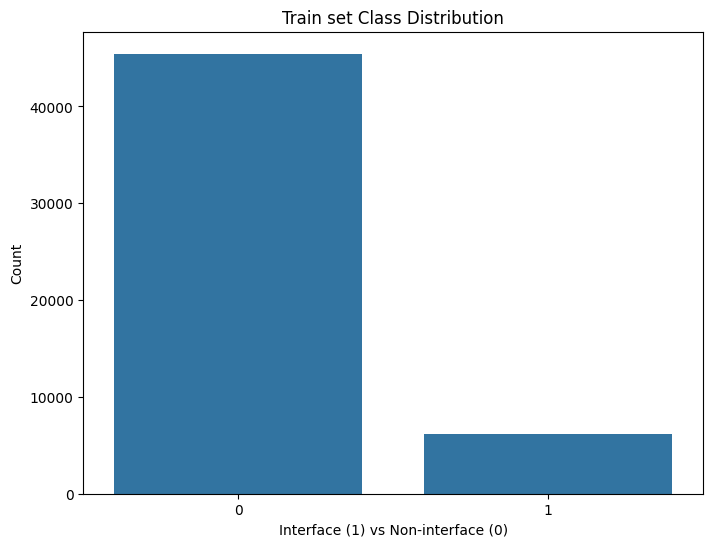

In [12]:
######################################################## check class distrubution for training set
target = "p_interface"
initial_class_counts = train_df[target].value_counts()
initial_class_percentages = train_df[target].value_counts(normalize=True) * 100

print("\nClass Distribution:")
for cls, count in initial_class_counts.items():
    percentage = initial_class_percentages[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")


# Visualize the overall class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=train_df)
plt.title("Train set Class Distribution")
plt.xlabel("Interface (1) vs Non-interface (0)")
plt.ylabel("Count")
plt.show()


In [13]:
######################################### Undersampling and Ovesampling
import random
random.seed(42)
#Compute the number of interface occurrences per protein in the training set.
#Since target is binary (0 or 1), summing gives the count for interface per protein.
protein_interface_counts = train_df.groupby("uniprot_id")[target].sum()

# Calculate mean interface counts 
mean_counts = protein_interface_counts.mean()

# Define threshold for Undersampling
threshold_under = mean_counts 
print("Threshold for Undersampling:", threshold_under)

# Define threshold for Oversampling 
threshold_over = mean_counts * 1.5
print("Threshold for Oversampling:", threshold_over)


#Group proteins based on whether their interface count is <= threshold or > threshold (UNDERSAMPLING)
group_low_under = protein_interface_counts[protein_interface_counts <= threshold_under].index.tolist()
group_high_under = protein_interface_counts[protein_interface_counts > threshold_under].index.tolist()

#Group proteins based on whether their interface count is <= threshold or > threshold (OVERSAMPLING)
group_low_over = protein_interface_counts[protein_interface_counts <= threshold_over].index.tolist()
group_high_over = protein_interface_counts[protein_interface_counts > threshold_over].index.tolist()

print("Number of proteins in group_low (<= threshold) for Undersampling:", len(group_low_under))
print("Number of proteins in group_high (> threshold) for Undersampling:", len(group_high_under))

print("Number of proteins in group_low (<= threshold) for Oversampling:", len(group_low_over))
print("Number of proteins in group_high (> threshold) for Oversampling:", len(group_high_over))


# Randomly sample proteins from group low (Undersampling)
# number of proteins to sample
sample_size = 60 
# Randomly sample proteins from group_low
group_low_undersampled = random.sample(group_low_under, min(sample_size, len(group_low_under)))


# Manually define how many proteins to add (Oversampling)
k_num = 50

# Randomly oversample group_high
group_high_duplicates = random.choices(group_high_over, k= k_num)


# Combine the low group undersampled and the original high group - for Undersampling
selected_proteins_under = list(group_low_undersampled) + list(group_high_under)
print("Number of proteins after undersampling:", len(selected_proteins_under))

# Combine the original low group with the oversampled proteins of the high group - for Oversampling
selected_proteins_over = list(group_high_over) + list(group_low_over) + list(group_high_duplicates)
print("Number of proteins after oversampling:", len(selected_proteins_over))

train_df_undersampled = train_df[train_df['uniprot_id'].isin(selected_proteins_under)]
train_df_oversampled = train_df[train_df['uniprot_id'].isin(selected_proteins_over)]

# add the duplicates from oversampling as a dataframe
group_high_duplicates_df = train_df[train_df['uniprot_id'].isin(group_high_duplicates)]
train_df_oversampled = pd.concat([train_df_oversampled, group_high_duplicates_df])

class_counts_u = train_df_undersampled[target].value_counts()
class_percentages_u = train_df_undersampled[target].value_counts(normalize=True) * 100

print("\nClass Distribution after Undersampling:")
for cls, count in class_counts_u.items():
    percentage = class_percentages_u[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")

class_counts_o = train_df_oversampled[target].value_counts()
class_percentages_o = train_df_oversampled[target].value_counts(normalize=True) * 100

print("\nClass Distribution after Oversampling:")
for cls, count in class_counts_o.items():
    percentage = class_percentages_o[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")


Threshold for Undersampling: 34.043956043956044
Threshold for Oversampling: 51.065934065934066
Number of proteins in group_low (<= threshold) for Undersampling: 103
Number of proteins in group_high (> threshold) for Undersampling: 79
Number of proteins in group_low (<= threshold) for Oversampling: 143
Number of proteins in group_high (> threshold) for Oversampling: 39
Number of proteins after undersampling: 139
Number of proteins after oversampling: 232

Class Distribution after Undersampling:
Class 0: 34324 samples (86.17%)
Class 1: 5507 samples (13.83%)

Class Distribution after Oversampling:
Class 0: 51450 samples (86.41%)
Class 1: 8092 samples (13.59%)


In [14]:
# Define features and target for training set after undersampling and oversampling
X_train_undersampled = train_df_undersampled.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
y_train_undersampled = train_df_undersampled[target]

X_train_oversampled = train_df_oversampled.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
y_train_oversampled = train_df_oversampled[target]


<Figure size 800x500 with 0 Axes>

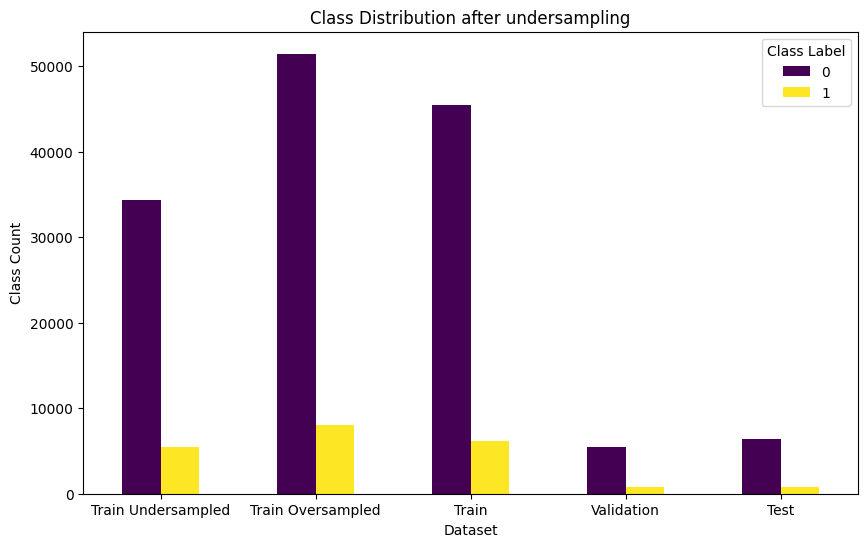

In [15]:
# Count occurrences of each class in train, val, and test sets
train_counts_under = y_train_undersampled.value_counts().sort_index()
train_counts_over = y_train_oversampled.value_counts().sort_index()
train_counts = y_train.value_counts().sort_index()
val_counts = y_val.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

# Create a DataFrame for visualization
class_distribution = pd.DataFrame({
    "Train Undersampled": train_counts_under,
    "Train Oversampled": train_counts_over,
    "Train": train_counts,
    "Validation": val_counts,
    "Test": test_counts
}).T  # Transpose for better plotting

# Plot the class distribution
plt.figure(figsize=(8, 5))
class_distribution.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.xlabel("Dataset")
plt.ylabel("Class Count")
plt.title("Class Distribution after undersampling")
plt.xticks(rotation=0)
plt.legend(title="Class Label")
plt.show()


In [16]:
################################################## scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train_undersampled = scaler.fit_transform(X_train_undersampled)
X_train_oversampled = scaler.fit_transform(X_train_oversampled)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

Confusion Matrix:
[[6394    0]
 [ 823    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.44      0.50      0.47      7217
weighted avg       0.78      0.89      0.83      7217



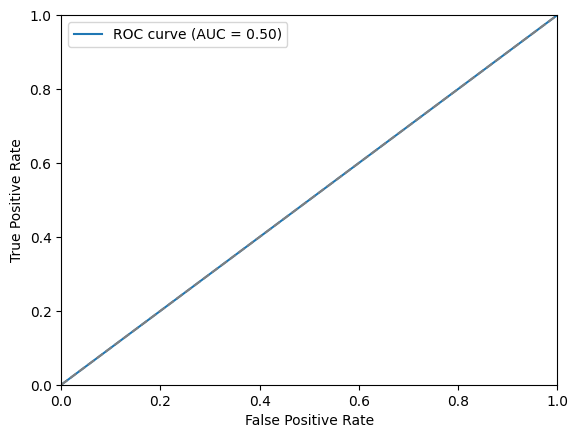

In [17]:
################################################## Dummy Classifier

# Create a majority class classifier
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit on the training data
dummy_clf.fit(X_train, y_train)

# Predict on the test set
#y_pred_dummy = dummy_clf.predict(X_test)
# Predict probabilities for the positive class (class 1)
y_prob_dummy = dummy_clf.predict_proba(X_test)[:, 1]
# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_dummy = (y_prob_dummy >= 0.5).astype(int)


# Compute ROC curve and AUC
fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_test, y_pred_dummy)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_prob_dummy))
print("\nClassification Report:")
print(classification_report(y_test, y_prob_dummy, zero_division=0))

plt.plot(fpr_dummy, tpr_dummy, label=f"ROC curve (AUC = {roc_auc_dummy:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [18]:
#################################################### Logistic regression 
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix

# Initialize and fit the Logistic Regression model
model = model = LogisticRegression( 
    max_iter=10000,       
    class_weight='balanced' 
)
model.fit(X_train, y_train)

# Predict probabilities for the positive class
y_pred_proba_LR = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_LR = (y_pred_proba_LR >= 0.5).astype(int)

# Calculate log loss
loss = log_loss(y_test, y_pred_proba_LR)
print("Log Loss: {:.4f}".format(loss))

# Calculate accuracy for reference
accuracy = accuracy_score(y_test, y_pred_LR)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_LR))

# Confusion matrix for more insight
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_LR))


Log Loss: 0.5301
Accuracy: 72.40%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      6394
           1       0.20      0.49      0.29       823

    accuracy                           0.72      7217
   macro avg       0.56      0.62      0.56      7217
weighted avg       0.84      0.72      0.77      7217


Confusion Matrix:
[[4825 1569]
 [ 423  400]]


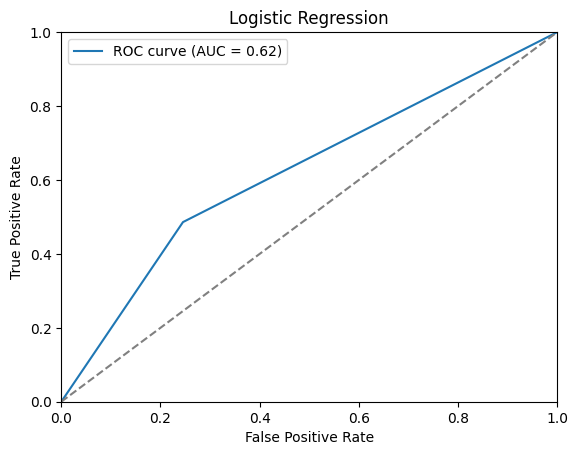

In [19]:
################################################# print results Logistic regression

# Compute ROC curve with continuous probabilities
fpr_LR, tpr_LR, thresholds = roc_curve(y_test, y_pred_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)

plt.plot(fpr_LR, tpr_LR, label=f"ROC curve (AUC = {roc_auc_LR:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Log Loss: 0.5375
Accuracy: 72.32%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      6394
           1       0.20      0.48      0.29       823

    accuracy                           0.72      7217
   macro avg       0.56      0.62      0.56      7217
weighted avg       0.84      0.72      0.77      7217


Confusion Matrix:
[[4820 1574]
 [ 424  399]]


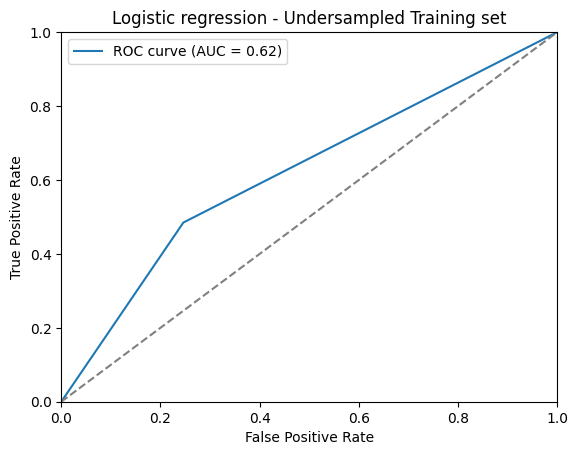

In [20]:
#################################################### Logistic regression - Undersampled Training set 
# Initialize and fit the Logistic Regression model
model = model = LogisticRegression( 
    max_iter=10000,       
    class_weight='balanced' 
)
model.fit(X_train_undersampled, y_train_undersampled)

# Predict probabilities for the positive class
y_pred_proba_LR_under = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_LR_under = (y_pred_proba_LR_under >= 0.5).astype(int)


# Calculate log loss
loss = log_loss(y_test, y_pred_proba_LR_under)
print("Log Loss: {:.4f}".format(loss))

# Calculate accuracy for reference
accuracy = accuracy_score(y_test, y_pred_LR_under)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_LR_under))

# Confusion matrix for more insight
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_LR_under))


# Compute ROC curve with continuous probabilities
fpr_LR_under, tpr_LR_under, thresholds_under = roc_curve(y_test, y_pred_LR_under)
roc_auc_LR_under = auc(fpr_LR_under, tpr_LR_under)

plt.plot(fpr_LR_under, tpr_LR_under, label=f"ROC curve (AUC = {roc_auc_LR_under:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Logistic regression - Undersampled Training set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Log Loss: 0.5339
Accuracy: 72.68%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      6394
           1       0.21      0.50      0.30       823

    accuracy                           0.73      7217
   macro avg       0.57      0.63      0.56      7217
weighted avg       0.84      0.73      0.77      7217


Confusion Matrix:
[[4830 1564]
 [ 408  415]]


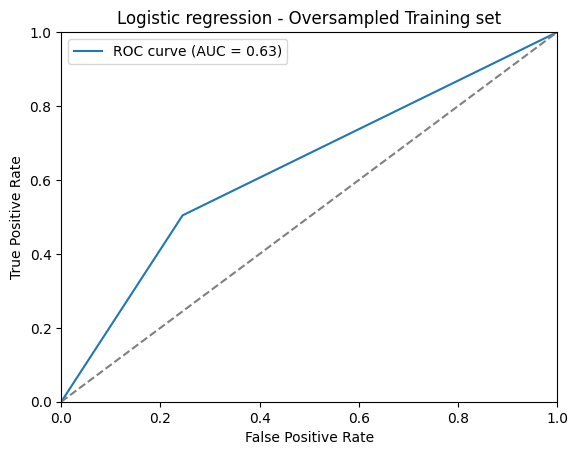

In [21]:
#################################################### Logistic regression - Oversampled Training set 
# Initialize and fit the Logistic Regression model
model = model = LogisticRegression( 
    max_iter=10000,       
    class_weight='balanced' 
)
model.fit(X_train_oversampled, y_train_oversampled)

# Predict probabilities for the positive class
y_pred_proba_LR_over = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_LR_over = (y_pred_proba_LR_over >= 0.5).astype(int)

# Calculate log loss
loss = log_loss(y_test, y_pred_proba_LR_over)
print("Log Loss: {:.4f}".format(loss))

# Calculate accuracy for reference
accuracy = accuracy_score(y_test, y_pred_LR_over)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_LR_over))

# Confusion matrix for more insight
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_LR_over))

# Compute ROC curve with continuous probabilities
fpr_LR_over, tpr_LR_over, thresholds_over = roc_curve(y_test, y_pred_LR_over)
roc_auc_LR_over = auc(fpr_LR_over, tpr_LR_over)

plt.plot(fpr_LR_over, tpr_LR_over, label=f"ROC curve (AUC = {roc_auc_LR_over:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Logistic regression - Oversampled Training set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [22]:
###################################################### hyperparamtater tuning Random Foretst
param_grid_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

###################################################### set the class weights here

grid_RF = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight=class_weights), 
    param_grid_RF,
    scoring='accuracy',
    n_jobs=-1
)
grid_RF.fit(X_val, y_val)

print("----- Random Forest Hyperparameter Tuning -----")
print("Best Parameters (RF):", grid_RF.best_params_)
print("Best Validation Accuracy (RF):", grid_RF.best_score_)
best_rf = grid_RF.best_estimator_


----- Random Forest Hyperparameter Tuning -----
Best Parameters (RF): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Validation Accuracy (RF): 0.7698130532610385


Accuracy: 0.89
Precision: 0.52
Recall: 0.01
F1 Score: 0.03
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.52      0.01      0.03       823

    accuracy                           0.89      7217
   macro avg       0.70      0.51      0.48      7217
weighted avg       0.85      0.89      0.84      7217



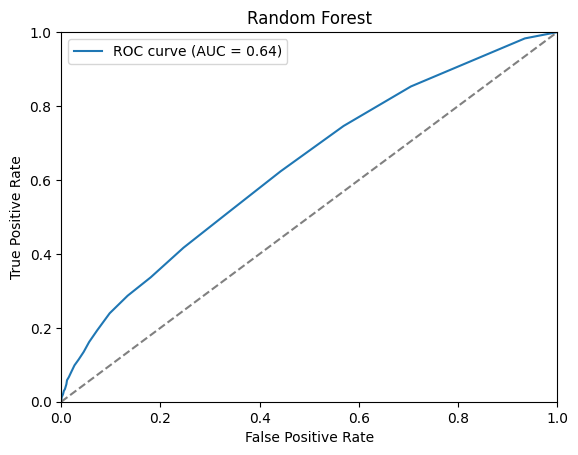

In [23]:
################################################# run RF on trainings data
# fit on training data 
best_rf.fit(X_train, y_train)

y_pred_RF = best_rf.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_RF = (y_pred_RF >= 0.5).astype(int)

# Evaluate
accuracy_RF  = accuracy_score(y_test, y_pred_class_RF)
precision_RF = precision_score(y_test, y_pred_class_RF, zero_division=0)
recall_RF    = recall_score(y_test, y_pred_class_RF, zero_division=0)
f1_RF        = f1_score(y_test, y_pred_class_RF, zero_division=0)

############################################################### print score radndom forest

print(f"Accuracy: {accuracy_RF:.2f}")
print(f"Precision: {precision_RF:.2f}")
print(f"Recall: {recall_RF:.2f}")
print(f"F1 Score: {f1_RF:.2f}")

print(classification_report(y_test, y_pred_class_RF, zero_division=0))

# Use continuous probabilities for the ROC curve
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_pred_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

plt.plot(fpr_RF, tpr_RF, label=f"ROC curve (AUC = {roc_auc_RF:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Accuracy: 0.89
Precision: 0.48
Recall: 0.03
F1 Score: 0.06
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.48      0.03      0.06       823

    accuracy                           0.89      7217
   macro avg       0.68      0.51      0.50      7217
weighted avg       0.84      0.89      0.84      7217



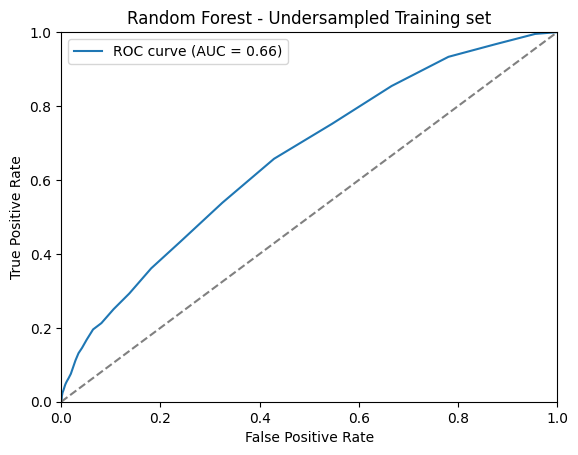

In [24]:
################################################# run RF on training data UNDERSAMPLED
# fit on trainingsdata 
best_rf.fit(X_train_undersampled, y_train_undersampled)

y_pred_RF = best_rf.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_RF = (y_pred_RF >= 0.5).astype(int)

# Evaluate
accuracy_RF  = accuracy_score(y_test, y_pred_class_RF)
precision_RF = precision_score(y_test, y_pred_class_RF, zero_division=0)
recall_RF    = recall_score(y_test, y_pred_class_RF, zero_division=0)
f1_RF        = f1_score(y_test, y_pred_class_RF, zero_division=0)

############################################################### print score radndom forest
print(f"Accuracy: {accuracy_RF:.2f}")
print(f"Precision: {precision_RF:.2f}")
print(f"Recall: {recall_RF:.2f}")
print(f"F1 Score: {f1_RF:.2f}")

print(classification_report(y_test, y_pred_class_RF, zero_division=0))

# Use continuous probabilities for the ROC curve
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_pred_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

plt.plot(fpr_RF, tpr_RF, label=f"ROC curve (AUC = {roc_auc_RF:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Random Forest - Undersampled Training set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Accuracy: 0.89
Precision: 0.54
Recall: 0.02
F1 Score: 0.03
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.54      0.02      0.03       823

    accuracy                           0.89      7217
   macro avg       0.71      0.51      0.49      7217
weighted avg       0.85      0.89      0.84      7217



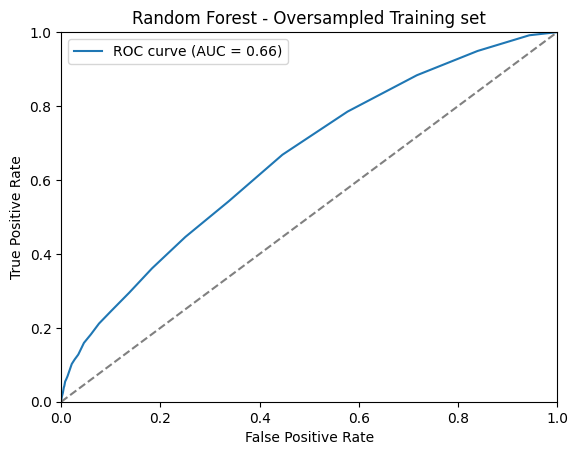

In [25]:
################################################# run RF on trainings data OVERSAMPLED
# fit on trainingsdata 
best_rf.fit(X_train_oversampled, y_train_oversampled)

# Predict probabilities on the test set (probability for the positive class)
y_pred_RF_over = best_rf.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_RF_over = (y_pred_RF_over >= 0.5).astype(int)

# Evaluate predictions
accuracy_RF_over  = accuracy_score(y_test, y_pred_class_RF_over)
precision_RF_over = precision_score(y_test, y_pred_class_RF_over, zero_division=0)
recall_RF_over    = recall_score(y_test, y_pred_class_RF_over, zero_division=0)
f1_RF_over        = f1_score(y_test, y_pred_class_RF_over, zero_division=0)

###############################################################
# Print Random Forest performance scores
print(f"Accuracy: {accuracy_RF_over:.2f}")
print(f"Precision: {precision_RF_over:.2f}")
print(f"Recall: {recall_RF_over:.2f}")
print(f"F1 Score: {f1_RF_over:.2f}")

print(classification_report(y_test, y_pred_class_RF_over, zero_division=0))

# Use continuous probabilities for the ROC curve
fpr_RF_over, tpr_RF_over, thresholds = roc_curve(y_test, y_pred_RF_over)
roc_auc_RF_over = auc(fpr_RF_over, tpr_RF_over)

plt.plot(fpr_RF_over, tpr_RF_over, label=f"ROC curve (AUC = {roc_auc_RF_over:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Random Forest - Oversampled Training set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [26]:
############################################### hyper paramter tuning XGBoost

param_grid_XGB = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_XGB = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, class_weight=class_weights),
    param_grid_XGB, 
    scoring='accuracy',
    n_jobs=-1
)

# Perform hyperparameter tuning
grid_XGB.fit(X_val, y_val)

# Print best hyperparameters and best validation accuracy
print("----- XGBoost Hyperparameter Tuning -----")
print("Best Parameters (XGB):", grid_XGB.best_params_)
print("Best Validation Accuracy (XGB):", grid_XGB.best_score_)

# Get the best model
best_xgb = grid_XGB.best_estimator_

----- XGBoost Hyperparameter Tuning -----
Best Parameters (XGB): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best Validation Accuracy (XGB): 0.7263744019184142


c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:29:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Performance:
Accuracy: 0.89
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.44      0.50      0.47      7217
weighted avg       0.78      0.89      0.83      7217



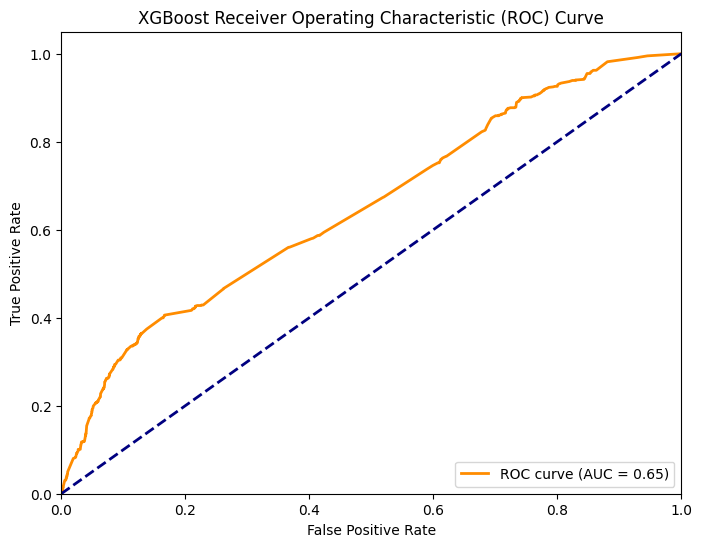

In [27]:
############################################### running XGBoost

# Re-fit the best estimator using the training data (X_train, y_train)
best_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred_XGB = best_xgb.predict_proba(X_test)[:, 1]
# Convert probabilities to binary class predictions using a threshold of 0.5
y_pred_class_XGB = [1 if prob >= 0.5 else 0 for prob in y_pred_XGB]

# Evaluate the classifier
accuracy_XGB = accuracy_score(y_test, y_pred_class_XGB)
precision_XGB = precision_score(y_test, y_pred_class_XGB, zero_division=0)
recall_XGB = recall_score(y_test, y_pred_class_XGB, zero_division=0)
f1_XGB = f1_score(y_test, y_pred_class_XGB, zero_division=0)

############################################### printing score XGBoost
print("XGBoost Classifier Performance:")
print(f"Accuracy: {accuracy_XGB:.2f}")
print(f"Precision: {precision_XGB:.2f}")
print(f"Recall: {recall_XGB:.2f}")
print(f"F1 Score: {f1_XGB:.2f}")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_XGB, zero_division=0))

# Compute the ROC curve and ROC-AUC using the predicted probabilities
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(y_test, y_pred_XGB)
roc_auc_XGB = auc(fpr_XGB, tpr_XGB)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_XGB, tpr_XGB, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_XGB:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Performance (Undersampled Training Data):
Accuracy: 0.89
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.44      0.50      0.47      7217
weighted avg       0.78      0.89      0.83      7217



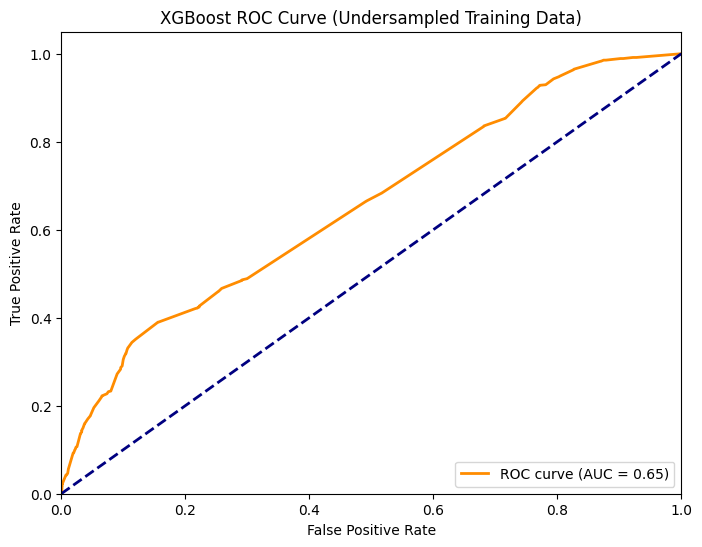

In [28]:
############################################## running XGBoost with undersampled training data

# Re-fit the best estimator using the undersampled training data (ensure you pass both features and labels)
best_xgb.fit(X_train_undersampled, y_train_undersampled)

# Predict on the test set using probability estimates for the positive class
y_pred_XGB_under = best_xgb.predict_proba(X_test)[:, 1]

# Convert probabilities to binary class predictions using a threshold of 0.5
y_pred_class_XGB_under = [1 if prob >= 0.5 else 0 for prob in y_pred_XGB_under]

# Evaluate the classifier
accuracy_XGB_under = accuracy_score(y_test, y_pred_class_XGB_under)
precision_XGB_under = precision_score(y_test, y_pred_class_XGB_under, zero_division=0)
recall_XGB_under = recall_score(y_test, y_pred_class_XGB_under, zero_division=0)
f1_XGB_under = f1_score(y_test, y_pred_class_XGB_under, zero_division=0)

############################################### printing score XGBoost (Undersampled Training Data)
print("XGBoost Classifier Performance (Undersampled Training Data):")
print(f"Accuracy: {accuracy_XGB_under:.2f}")
print(f"Precision: {precision_XGB_under:.2f}")
print(f"Recall: {recall_XGB_under:.2f}")
print(f"F1 Score: {f1_XGB_under:.2f}")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_XGB_under, zero_division=0))

# Compute the ROC curve and ROC-AUC using the predicted probabilities
fpr_XGB_under, tpr_XGB_under, thresholds_XGB_under = roc_curve(y_test, y_pred_XGB_under)
roc_auc_XGB_under = auc(fpr_XGB_under, tpr_XGB_under)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_XGB_under, tpr_XGB_under, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_XGB_under:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve (Undersampled Training Data)')
plt.legend(loc='lower right')
plt.show()



c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Performance (Oversampled Training Data):
Accuracy: 0.89
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.44      0.50      0.47      7217
weighted avg       0.78      0.89      0.83      7217



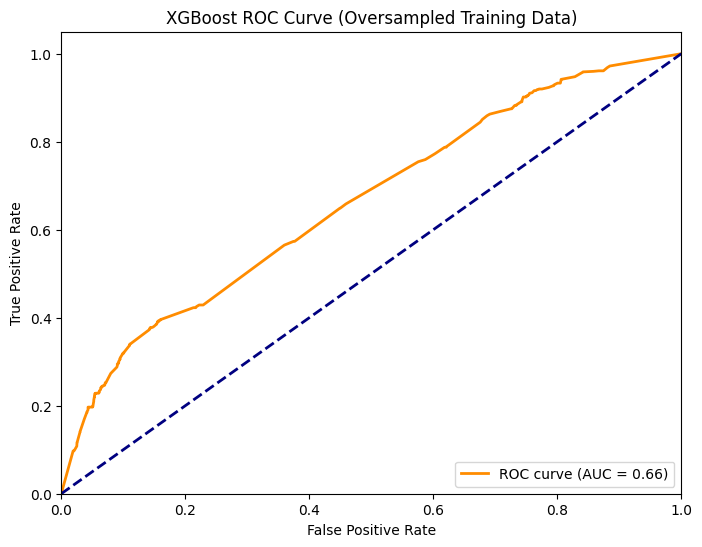

In [29]:
############################################### running XGBoost with oversampled training data

# Re-fit the best estimator using the oversampled training data (ensure you pass both features and labels)
best_xgb.fit(X_train_oversampled, y_train_oversampled)

# Predict on the test set using probability estimates for the positive class
y_pred_XGB_over = best_xgb.predict_proba(X_test)[:, 1]

# Convert probabilities to binary class predictions using a threshold of 0.5
y_pred_class_XGB_over = [1 if prob >= 0.5 else 0 for prob in y_pred_XGB_over]

# Evaluate the classifier
accuracy_XGB_over = accuracy_score(y_test, y_pred_class_XGB_over)
precision_XGB_over = precision_score(y_test, y_pred_class_XGB_over, zero_division=0)
recall_XGB_over = recall_score(y_test, y_pred_class_XGB_over, zero_division=0)
f1_XGB_over = f1_score(y_test, y_pred_class_XGB_over, zero_division=0)

############################################### printing score XGBoost (Oversampled Training Data)
print("XGBoost Classifier Performance (Oversampled Training Data):")
print(f"Accuracy: {accuracy_XGB_over:.2f}")
print(f"Precision: {precision_XGB_over:.2f}")
print(f"Recall: {recall_XGB_over:.2f}")
print(f"F1 Score: {f1_XGB_over:.2f}")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_XGB_over, zero_division=0))

# Compute the ROC curve and ROC-AUC using the predicted probabilities
fpr_XGB_over, tpr_XGB_over, thresholds_XGB_over = roc_curve(y_test, y_pred_XGB_over)
roc_auc_XGB_over = auc(fpr_XGB_over, tpr_XGB_over)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_XGB_over, tpr_XGB_over, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_XGB_over:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve (Oversampled Training Data)')
plt.legend(loc='lower right')
plt.show()


In [30]:
################################################## make neural netwrok
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Binary classification (0/1)
])

# Compile Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])



c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
###################################################### train model and set the class weights

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  
    batch_size=32,
    verbose=1,
    class_weight=class_weights
)


Epoch 1/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5540 - auc: 0.5942 - loss: 0.6918 - val_accuracy: 0.5753 - val_auc: 0.7195 - val_loss: 0.6248
Epoch 2/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6160 - auc: 0.6940 - loss: 0.6131 - val_accuracy: 0.6485 - val_auc: 0.7202 - val_loss: 0.5950
Epoch 3/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6492 - auc: 0.7182 - loss: 0.5907 - val_accuracy: 0.6593 - val_auc: 0.7251 - val_loss: 0.5962
Epoch 4/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6657 - auc: 0.7156 - loss: 0.5901 - val_accuracy: 0.6587 - val_auc: 0.7352 - val_loss: 0.5902
Epoch 5/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6693 - auc: 0.7331 - loss: 0.5784 - val_accuracy: 0.6806 - val_auc: 0.7254 - val_loss: 0.5725
Epoch 6/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6733 - auc: 0.7389 - loss: 0.5735 - val_accuracy: 0.6728 - val_auc: 0.7304 - val_loss: 0.5803
Epoch 7/50
1614/1614 ━━━━━━━

In [32]:
####################################################### caluculate scores neural network
y_pred_probs_NN = model.predict(X_test).flatten()  # Continuous outputs, shape = (num_samples,)

# 2. Convert probabilities to binary predictions at threshold=0.5
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)



226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step


Accuracy: 0.69
Precision: 0.19
Recall: 0.55
F1 Score: 0.29

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      6394
           1       0.19      0.55      0.29       823

    accuracy                           0.69      7217
   macro avg       0.56      0.63      0.54      7217
weighted avg       0.84      0.69      0.74      7217



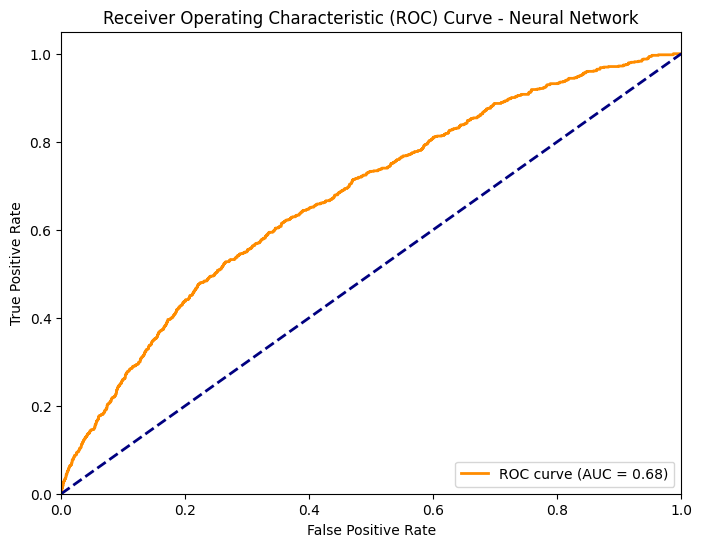

In [33]:
######################################################## print scores NN
print(f"Accuracy: {accuracy_NN:.2f}")
print(f"Precision: {precision_NN:.2f}")
print(f"Recall: {recall_NN:.2f}")
print(f"F1 Score: {f1_NN:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_NN, zero_division=0))

# 5. Compute and plot ROC curve (using continuous probabilities)
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Neural Network')
plt.legend(loc='lower right')
plt.show()

Epoch 1/50


c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5186 - auc_1: 0.5627 - loss: 0.7748 - val_accuracy: 0.5527 - val_auc_1: 0.6855 - val_loss: 0.6531
Epoch 2/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5597 - auc_1: 0.6689 - loss: 0.6629 - val_accuracy: 0.5731 - val_auc_1: 0.7096 - val_loss: 0.6457
Epoch 3/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5847 - auc_1: 0.7006 - loss: 0.6351 - val_accuracy: 0.5667 - val_auc_1: 0.7178 - val_loss: 0.6555
Epoch 4/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6027 - auc_1: 0.7120 - loss: 0.6348 - val_accuracy: 0.5809 - val_auc_1: 0.7261 - val_loss: 0.6408
Epoch 5/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6162 - auc_1: 0.7199 - loss: 0.6266 - val_accuracy: 0.6257 - val_auc_1: 0.7253 - val_loss: 0.6198
Epoch 6/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6160 - auc_1: 0.7244 - loss: 0.6257 - val_accuracy: 0.5799 - val_auc_1: 0.7347 - val_loss: 0.6444
Epoch 7/50
1245

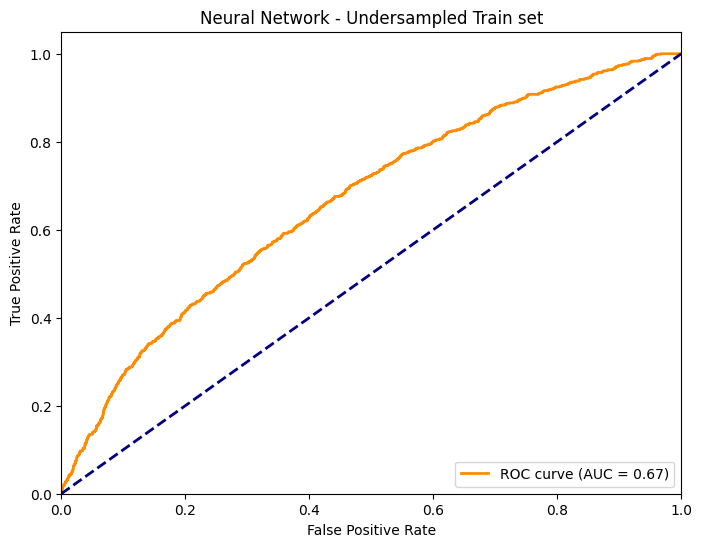

In [34]:
######################################################## Neural Network for Undersampled Train set
# Make neural netwrok
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_undersampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Binary classification (0/1)
])

# Compile Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])


# Train model and set the class weights
history = model.fit(
    X_train_undersampled, y_train_undersampled,
    validation_data=(X_val, y_val),
    epochs=50,  
    batch_size=32,
    verbose=1,
    class_weight=class_weights
)

# caluculate scores neural network
y_pred_probs_NN = model.predict(X_test).flatten()  # Continuous outputs, shape = (num_samples,)

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)

# print scores NN
print(f"Accuracy: {accuracy_NN:.2f}")
print(f"Precision: {precision_NN:.2f}")
print(f"Recall: {recall_NN:.2f}")
print(f"F1 Score: {f1_NN:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_NN, zero_division=0))

# Compute and plot ROC curve (using continuous probabilities)
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network - Undersampled Train set')
plt.legend(loc='lower right')
plt.show()


Epoch 1/50


c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1861/1861 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5209 - auc_2: 0.5773 - loss: 0.7585 - val_accuracy: 0.5206 - val_auc_2: 0.6997 - val_loss: 0.6691
Epoch 2/50
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5677 - auc_2: 0.6866 - loss: 0.6457 - val_accuracy: 0.5701 - val_auc_2: 0.7284 - val_loss: 0.6341
Epoch 3/50
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5939 - auc_2: 0.7156 - loss: 0.6276 - val_accuracy: 0.5465 - val_auc_2: 0.7364 - val_loss: 0.6482
Epoch 4/50
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5977 - auc_2: 0.7255 - loss: 0.6171 - val_accuracy: 0.5780 - val_auc_2: 0.7112 - val_loss: 0.6342
Epoch 5/50
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6121 - auc_2: 0.7258 - loss: 0.6145 - val_accuracy: 0.5982 - val_auc_2: 0.7294 - val_loss: 0.6239
Epoch 6/50
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6086 - auc_2: 0.7316 - loss: 0.6131 - val_accuracy: 0.5855 - val_auc_2: 0.7230 - val_loss: 0.6289
Epoch 7/50
1861

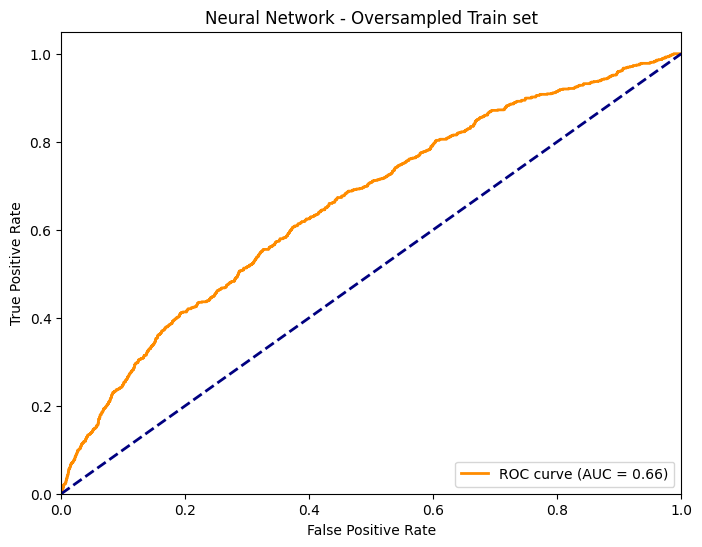

In [35]:
######################################################## Neural Network for Oversampled Train set
# Make neural netwrok
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_oversampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Binary classification (0/1)
])

# Compile Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])


# Train model and set the class weights
history = model.fit(
    X_train_oversampled, y_train_oversampled,
    validation_data=(X_val, y_val),
    epochs=50,  
    batch_size=32,
    verbose=1,
    class_weight=class_weights
)

# caluculate scores neural network
y_pred_probs_NN = model.predict(X_test).flatten()  # Continuous outputs, shape = (num_samples,)

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)

# print scores NN
print(f"Accuracy: {accuracy_NN:.2f}")
print(f"Precision: {precision_NN:.2f}")
print(f"Recall: {recall_NN:.2f}")
print(f"F1 Score: {f1_NN:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_NN, zero_division=0))

# Compute and plot ROC curve (using continuous probabilities)
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network - Oversampled Train set')
plt.legend(loc='lower right')
plt.show()


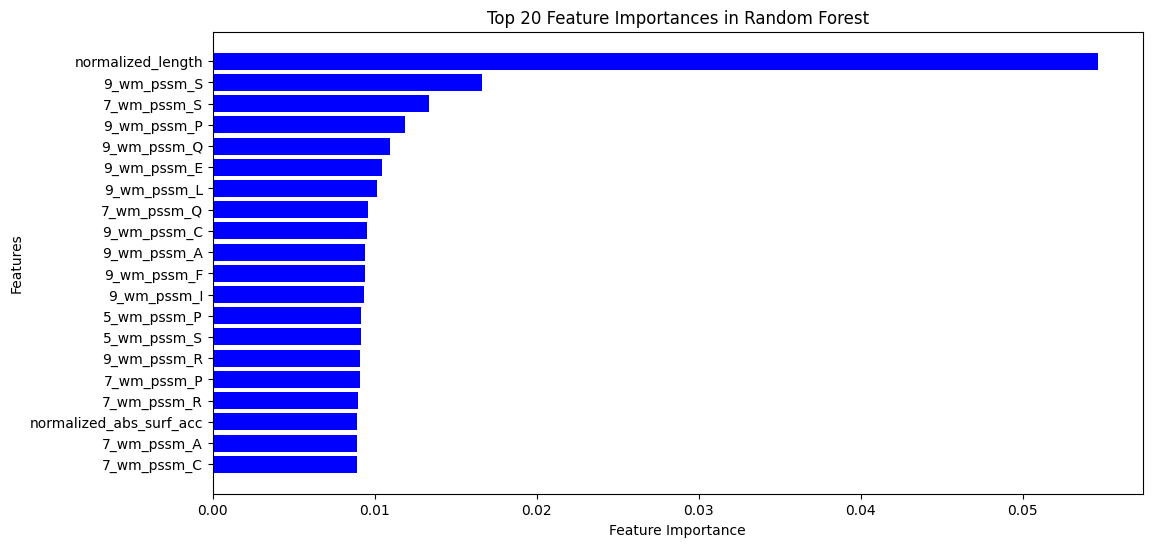

In [36]:
################## --> look at which rf we get this
importances = best_rf.feature_importances_
# Ensure you have the correct feature names
train_df_test = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength", "Unnamed: 0"])

# Ensure feature names match X_train
feature_names_test = train_df_test.columns  # Ensure X_train is a DataFrame

# Convert X_train (NumPy array) back to a DataFrame
X_train_names = pd.DataFrame(X_train, columns=feature_names_test)



# Create DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_test,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color='blue')
plt.gca().invert_yaxis()  # Invert y-axis so the most important feature is on top
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importances in Random Forest")
plt.show()


In [37]:
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_22
Received: inputs=['Tensor(shape=(100, 151))']
  warnings.warn(msg)
c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_22
Received: inputs=['Tensor(shape=(200, 151))']
  warnings.warn(msg)
c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't 

<Figure size 640x480 with 0 Axes>

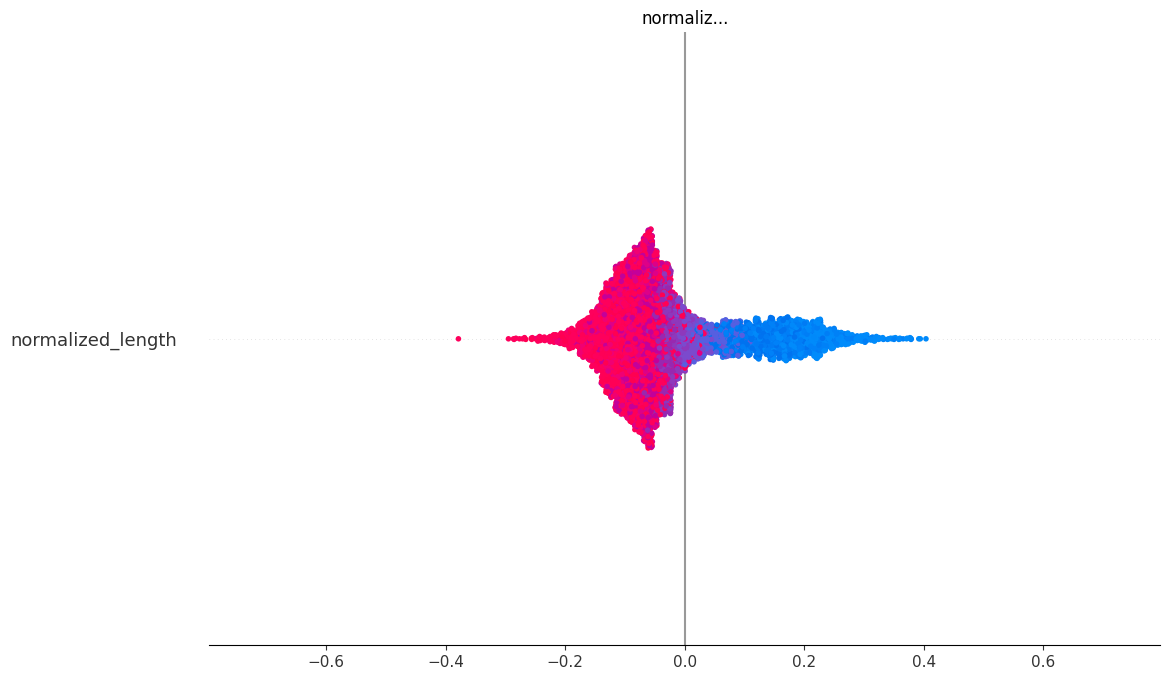

In [38]:
#global feature importance
test_df = test_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength", "Unnamed: 0"])

# Ensure feature names match X_train
feature_names_2 = test_df.columns  # Ensure X_train is a DataFrame

# Convert X_train (NumPy array) back to a DataFrame
X_test_names = pd.DataFrame(X_test, columns=feature_names_2)

# Then pass them to the summary plot:
shap.summary_plot(shap_values, X_test_names)

In [39]:
def build_model(hp):
    """Build and compile a Keras model, returning it."""
    model = Sequential()

    # Tune the number of units in the first layer
    units_input = hp.Int('units_input', min_value=128, max_value=512, step=128)
    model.add(Dense(units_input, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate
    lr = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')]
    )
    return model

In [40]:
class MyHyperband(kt.Hyperband):
    """
    Custom Hyperband tuner that also tunes 'batch_size' via run_trial()
    and returns final metrics to avoid the 'None' return error.
    """

    def run_trial(self, trial, x, y, **fit_kwargs):
        hp = trial.hyperparameters

        # 1) Define any training-related hyperparameters here
        fit_kwargs['batch_size'] = hp.Choice('batch_size', [32, 64, 128])
        # You could also tune epochs if you want:
        # fit_kwargs['epochs'] = hp.Int('epochs', min_value=10, max_value=30, step=5)

        # 2) Build the model using the current hyperparameters
        model = self.hypermodel.build(hp)

        # 3) Train the model
        history = model.fit(x, y, **fit_kwargs)

        # 4) Retrieve final metrics from history
        #    (Make sure 'val_loss' and 'val_AUC' are being tracked!)
        final_val_loss = history.history['val_loss'][-1]
        final_val_auc  = history.history['val_AUC'][-1]

        # 5) Update the trial with these metrics so the tuner can compare
        self.oracle.update_trial(
            trial.trial_id,
            {'val_loss': final_val_loss, 'val_AUC': final_val_auc}
        )

    
        # 7) **Return** the final metrics to avoid the None return error
        return {'val_loss': final_val_loss, 'val_AUC': final_val_auc}

In [41]:
############################################### setting up and running the hyperparameter tuning

# usign MyHyperband to search for optimale hyperparameters
tuner = MyHyperband(
    build_model,
    objective=kt.Objective("val_AUC", direction="max"),
    max_epochs=20,   
    factor=3,
    overwrite=True,
    directory="my_dir",
    project_name="nn_tuning"
)

# compute early stopping to overcome overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Run the hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=20,                    # set variable
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[stop_early],
    verbose=1
)


Trial 30 Complete [00h 00m 04s]
val_AUC: 0.7277693748474121

Best val_AUC So Far: 0.7379249334335327
Total elapsed time: 00h 07m 29s


In [42]:
########################################################### get paramters from hyper 
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
param_values = best_hps.values
print(param_values)


{'units_input': 128, 'learning_rate': 0.0005, 'batch_size': 64, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}



Training on Original dataset:
Epoch 1/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.5985 - accuracy: 0.5700 - loss: 0.7392 - val_AUC: 0.7142 - val_accuracy: 0.6528 - val_loss: 0.6021
Epoch 2/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.6968 - accuracy: 0.6492 - loss: 0.6155 - val_AUC: 0.7276 - val_accuracy: 0.6800 - val_loss: 0.5787
Epoch 3/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7149 - accuracy: 0.6590 - loss: 0.5980 - val_AUC: 0.7248 - val_accuracy: 0.6744 - val_loss: 0.5873
Epoch 4/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7295 - accuracy: 0.6750 - loss: 0.5777 - val_AUC: 0.7250 - val_accuracy: 0.6614 - val_loss: 0.5919
Epoch 5/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7401 - accuracy: 0.6767 - loss: 0.5746 - val_AUC: 0.7278 - val_accuracy: 0.6701 - val_loss: 0.5821
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step
Original - Accuracy: 0.73
Original - Precision: 0.20
Original - Recall: 0.43
Original - F1 Score: 0.27

Classification Report 

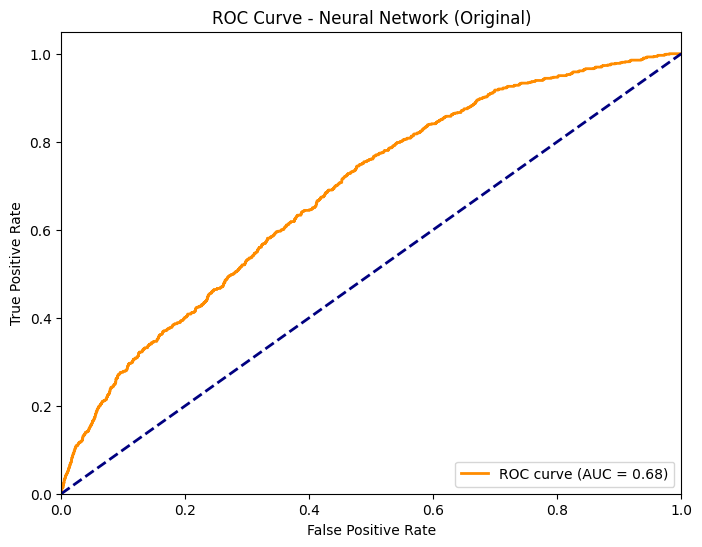


Training on Undersampled dataset:
Epoch 1/50


c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.5918 - accuracy: 0.5395 - loss: 0.7965 - val_AUC: 0.7217 - val_accuracy: 0.6027 - val_loss: 0.6579
Epoch 2/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.6783 - accuracy: 0.5928 - loss: 0.6721 - val_AUC: 0.7235 - val_accuracy: 0.6087 - val_loss: 0.6455
Epoch 3/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7094 - accuracy: 0.6069 - loss: 0.6337 - val_AUC: 0.7252 - val_accuracy: 0.6222 - val_loss: 0.6335
Epoch 4/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7225 - accuracy: 0.6182 - loss: 0.6264 - val_AUC: 0.7299 - val_accuracy: 0.6397 - val_loss: 0.6144
Epoch 5/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7269 - accuracy: 0.6243 - loss: 0.6148 - val_AUC: 0.7280 - val_accuracy: 0.6294 - val_loss: 0.6259
Epoch 6/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7357 - accuracy: 0.6284 - loss: 0.6120 - val_AUC: 0.7325 - val_accuracy: 0.6218 - val_loss: 0.6318
Epoch 7/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

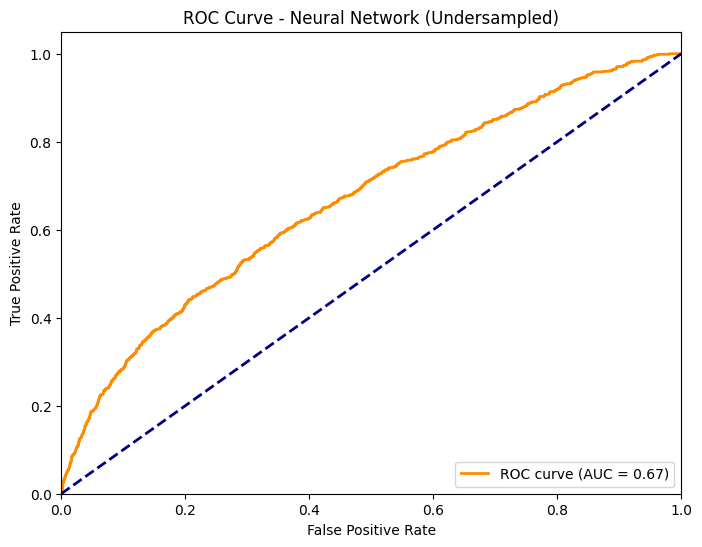


Training on Oversampled dataset:
Epoch 1/50


c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


931/931 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.6092 - accuracy: 0.5539 - loss: 0.7718 - val_AUC: 0.7140 - val_accuracy: 0.6051 - val_loss: 0.6442
Epoch 2/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7015 - accuracy: 0.6149 - loss: 0.6393 - val_AUC: 0.7185 - val_accuracy: 0.6086 - val_loss: 0.6377
Epoch 3/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7278 - accuracy: 0.6267 - loss: 0.6220 - val_AUC: 0.7271 - val_accuracy: 0.6342 - val_loss: 0.6169
Epoch 4/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7339 - accuracy: 0.6342 - loss: 0.6096 - val_AUC: 0.7175 - val_accuracy: 0.6175 - val_loss: 0.6280
Epoch 5/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7412 - accuracy: 0.6370 - loss: 0.6012 - val_AUC: 0.7287 - val_accuracy: 0.6445 - val_loss: 0.6044
Epoch 6/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7529 - accuracy: 0.6530 - loss: 0.5872 - val_AUC: 0.7165 - val_accuracy: 0.6324 - val_loss: 0.6208
Epoch 7/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

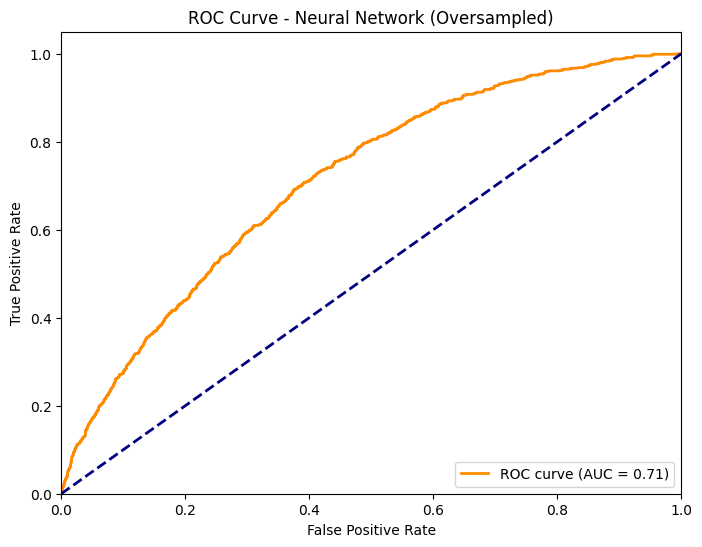

In [43]:
# Dictionary containing your training datasets
# Each key is a label, and the value is a tuple (X_train_current, y_train_current)
training_datasets = {
    "Original": (X_train, y_train),
    "Undersampled": (X_train_undersampled, y_train_undersampled),
    "Oversampled": (X_train_oversampled, y_train_oversampled)
}

# Dictionaries to store the trained models, training histories, and metrics for each dataset.
trained_models = {}
histories = {}
metrics = {}

for dataset_name, (X_train_current, y_train_current) in training_datasets.items():
    print(f"\nTraining on {dataset_name} dataset:")
    
    # Build a new model using the best hyperparameters from the tuner
    best_model = tuner.hypermodel.build(best_hps)
    
    # Train the model using the current training dataset
    history = best_model.fit(
        X_train_current, y_train_current,
        batch_size=best_hps.get('batch_size'),
        epochs=50,  # Adjust epochs as needed
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        callbacks=[stop_early]
    )
    
    # Save the trained model and its history
    trained_models[dataset_name] = best_model
    histories[dataset_name] = history
    
    # --- Evaluate the trained model on the test set ---
    # Get prediction probabilities and flatten the output (for a binary classification NN)
    y_pred_probs_NN = best_model.predict(X_test).flatten()
    # Convert probabilities to binary predictions using a threshold of 0.5
    y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)
    
    # Calculate performance metrics
    accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
    precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
    recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
    f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)
    
    # Print metrics for the current dataset
    print(f"{dataset_name} - Accuracy: {accuracy_NN:.2f}")
    print(f"{dataset_name} - Precision: {precision_NN:.2f}")
    print(f"{dataset_name} - Recall: {recall_NN:.2f}")
    print(f"{dataset_name} - F1 Score: {f1_NN:.2f}")
    
    # Print the detailed classification report
    print(f"\nClassification Report for {dataset_name} dataset:")
    print(classification_report(y_test, y_pred_class_NN, zero_division=0))
    
    # Compute the ROC curve and ROC-AUC
    fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
    roc_auc_NN = auc(fpr_NN, tpr_NN)
    
    # Store metrics in a dictionary for later reference if needed
    metrics[dataset_name] = {
        "accuracy": accuracy_NN,
        "precision": precision_NN,
        "recall": recall_NN,
        "f1": f1_NN,
        "roc_auc": roc_auc_NN
    }
    
    # Plot the ROC curve for the current dataset
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Neural Network ({dataset_name})')
    plt.legend(loc='lower right')
    plt.show()


In [44]:
#############################################use shap for other model

# Create SHAP DeepExplainer --> now uses last of the best models
explainer = shap.DeepExplainer(best_model, background)

# Compute SHAP values for test data
shap_values_2 = explainer.shap_values(X_test)

c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_396
Received: inputs=['Tensor(shape=(100, 151))']
  warnings.warn(msg)
c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_396
Received: inputs=['Tensor(shape=(200, 151))']
  warnings.warn(msg)
c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn'

<Figure size 640x480 with 0 Axes>

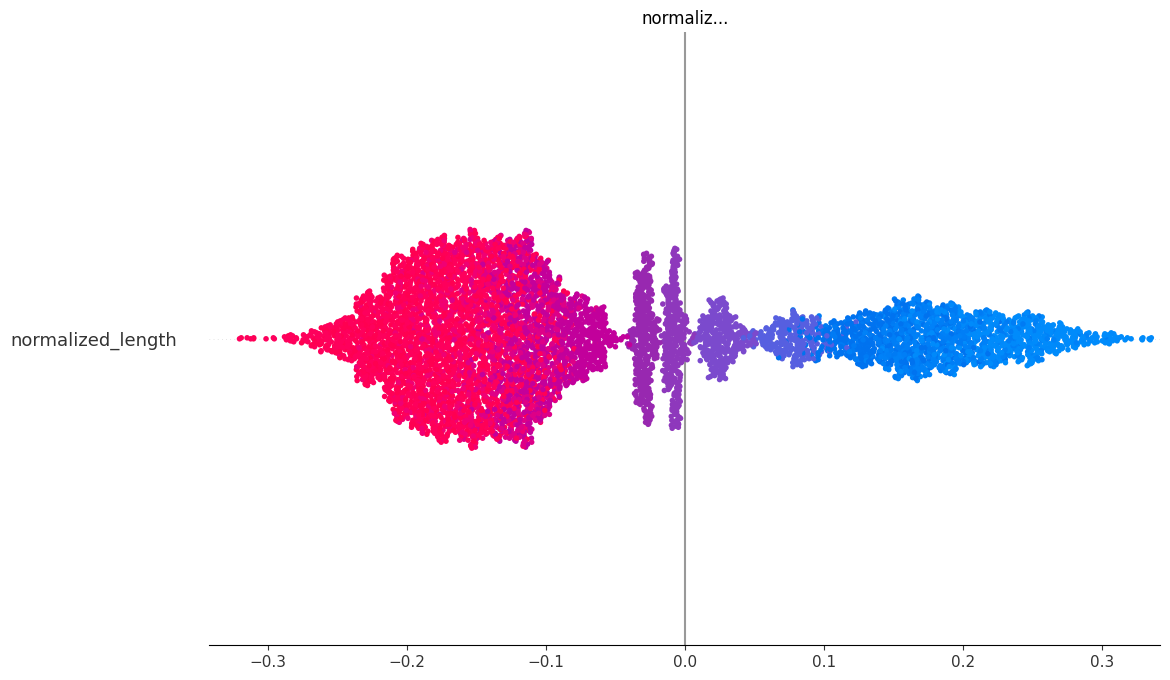

In [45]:
# Then pass them to the summary plot:
shap.summary_plot(shap_values_2, X_test_names)

In [46]:
################################################## getting normelized lenght
X_train_length = X_train[:, 0].reshape(-1, 1)  
X_test_length  = X_test[:, 0].reshape(-1, 1) 


In [47]:
################################################## running logistic regression with one variable
model_single = LogisticRegression()
model_single.fit(X_train, y_train)

LogisticRegression()

In [48]:
y_pred_probs_LR_single = model_single.predict_proba(X_test_length)[:, 1]

# Convert to binary predictions using a threshold of 0.5
y_pred_class_LR_single = (y_pred_probs_LR_single >= 0.5).astype(int)

# Evaluate with "LR_single" variable names
accuracy_LR_single  = accuracy_score(y_test, y_pred_class_LR_single)
precision_LR_single = precision_score(y_test, y_pred_class_LR_single, zero_division=0)
recall_LR_single    = recall_score(y_test, y_pred_class_LR_single, zero_division=0)
f1_LR_single        = f1_score(y_test, y_pred_class_LR_single, zero_division=0)

print("Accuracy (LR_single):", accuracy_LR_single)
print("Precision (LR_single):", precision_LR_single)
print("Recall (LR_single):", recall_LR_single)
print("F1 (LR_single):", f1_LR_single)

#print classification report
print(classification_report(y_test, y_pred_class_LR_single, zero_division=0))

ValueError: X has 1 features, but LogisticRegression is expecting 151 features as input.

In [ ]:
################################################## print results Linear regression
print(classification_report(y_test, y_pred_class_LR_single, zero_division=0))

# 2. Compute ROC curve with continuous probabilities
fpr_LR_single, tpr_LR_single, thresholds_LR_single = roc_curve(y_test, y_pred_probs_LR_single)
roc_auc_LR_single = auc(fpr_LR_single, tpr_LR_single)

# 3. Plot the ROC curve
plt.plot(fpr_LR_single, tpr_LR_single, label=f"LR_single ROC (AUC = {roc_auc_LR_single:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

NameError: name 'y_pred_class_LR_single' is not defined

In [49]:
################################################################################## permutation test using AUC frop
def permutation_importance_keras_auc(model, X, y, n_repeats=5, random_state=42):
    """
    model to see which features let the AUC drop most
    """
    #  Compute baseline AUC
    baseline_probs = model.predict(X).ravel()  # probabilities
    baseline_auc = roc_auc_score(y, baseline_probs)

    #random 
    rng = np.random.default_rng(random_state)
    importances = np.zeros(X.shape[1])

    # For each feature i shuffle it and measure AUC drop
    for i in range(X.shape[1]):
        score_decreases = []
        for _ in range(n_repeats):
            X_permuted = X.copy()  
            rng.shuffle(X_permuted[:, i])  
            perm_probs = model.predict(X_permuted).ravel()
            perm_auc = roc_auc_score(y, perm_probs)

            # how much dit the auc drop
            score_decreases.append(baseline_auc - perm_auc)

        # avarage drop feature in auc
        importances[i] = np.mean(score_decreases)
        
    #return outcome
    return importances, baseline_auc

In [50]:
########################################## running permutation test
importances, baseline_auc = permutation_importance_keras_auc(best_model, X_test, y_test)

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
226/226 ━━━

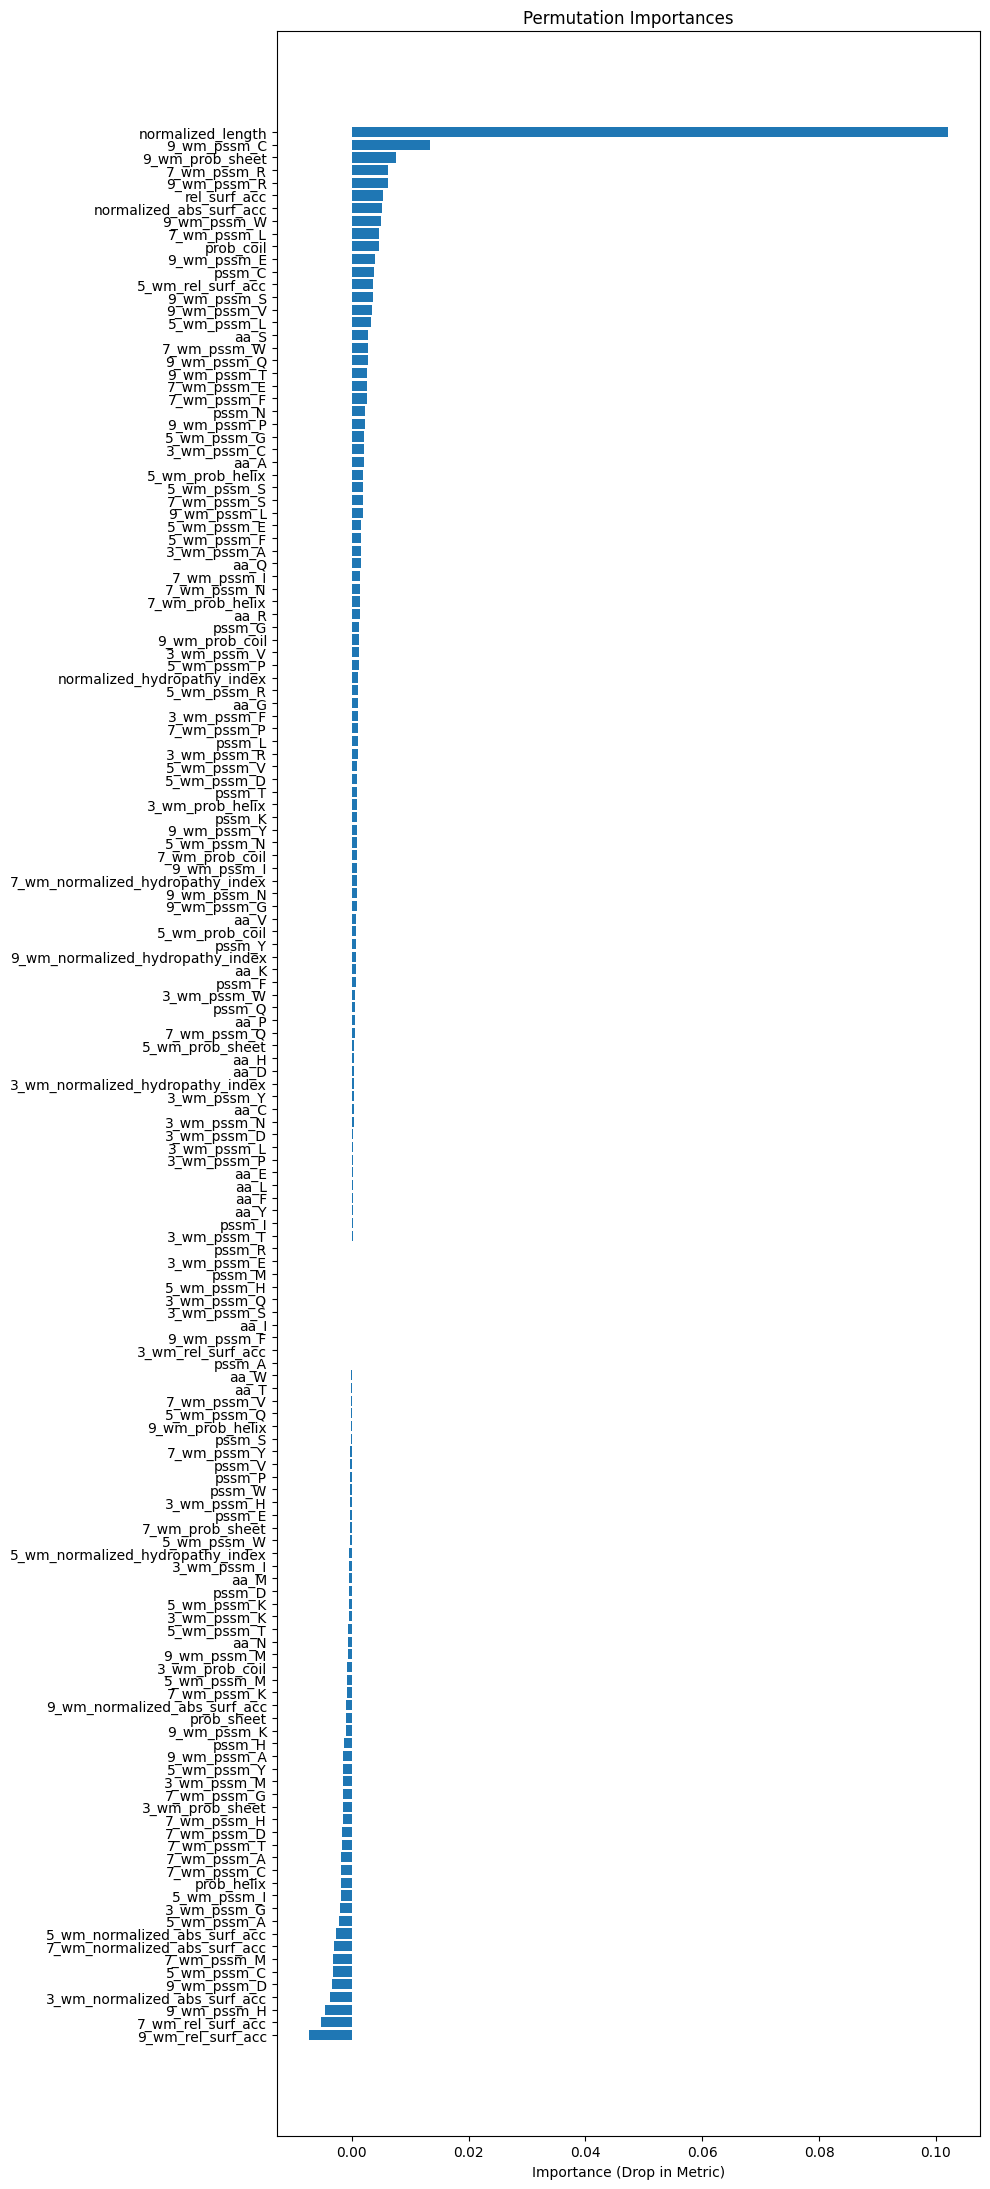

In [ ]:
############################################################## sort importance and plot inmpact

def plot_permutation_importances(importances, feature_names, title="Permutation Importances"):
    indices = np.argsort(importances)[::-1]  # sort descending
    sorted_importances = importances[indices]
    sorted_features = [feature_names[i] for i in indices]

    # make iit horizonontal and big so you read the names
    plt.figure(figsize=(10, 22))
   
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_features)
    
    plt.gca().invert_yaxis()
    
    plt.xlabel("Importance (Drop in Metric)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_permutation_importances(importances, feature_names_test)

In [56]:
# Remove the 'normalized_length' feature
X_train_without_length = np.delete(X_train, 0, axis=1)  
X_val_without_length   = np.delete(X_val, 0, axis=1)
X_test_without_length  = np.delete(X_test, 0, axis=1)

train_df_without_length = train_df_test.drop('normalized_length', axis=1)
feature_names_without_length = train_df_without_length.columns 

Epoch 1/50


c:\Users\vasso\Scientific Machine Learning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1614/1614 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5588 - auc_4: 0.5650 - loss: 0.7314 - val_accuracy: 0.5470 - val_auc_4: 0.6221 - val_loss: 0.6271
Epoch 2/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5880 - auc_4: 0.6401 - loss: 0.6283 - val_accuracy: 0.5255 - val_auc_4: 0.6103 - val_loss: 0.6592
Epoch 3/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5936 - auc_4: 0.6571 - loss: 0.6215 - val_accuracy: 0.5656 - val_auc_4: 0.6188 - val_loss: 0.6346
Epoch 4/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6010 - auc_4: 0.6722 - loss: 0.6182 - val_accuracy: 0.6222 - val_auc_4: 0.6189 - val_loss: 0.6304
Epoch 5/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6123 - auc_4: 0.6799 - loss: 0.6164 - val_accuracy: 0.5774 - val_auc_4: 0.6214 - val_loss: 0.6271
Epoch 6/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6075 - auc_4: 0.6897 - loss: 0.6055 - val_accuracy: 0.5772 - val_auc_4: 0.6297 - val_loss: 0.6347
Epoch 7/50
1614

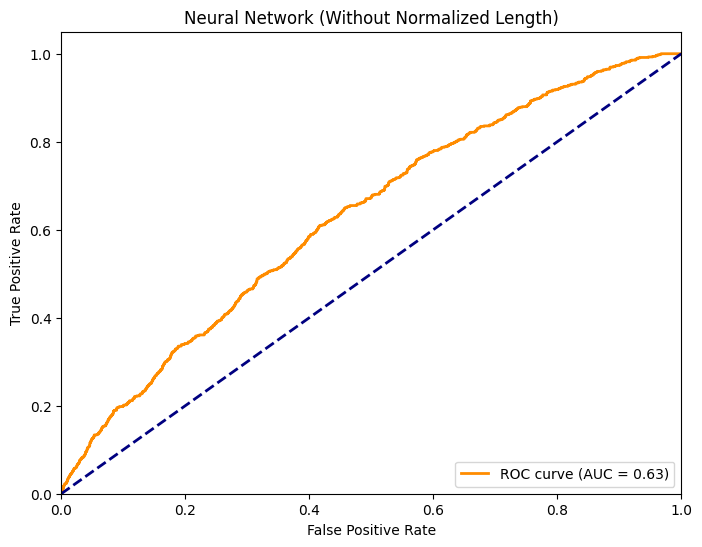

In [57]:
######################################################## Trying NN without normalized length

# Make neural netwrok
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_without_length.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Binary classification (0/1)
])

# Compile Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])


# Train model and set the class weights
history = model.fit(
    X_train_without_length, y_train,
    validation_data=(X_val_without_length, y_val),
    epochs=50,  
    batch_size=32,
    verbose=1,
    class_weight=class_weights
)

# caluculate scores neural network
y_pred_probs_NN = model.predict(X_test_without_length).flatten()  # Continuous outputs, shape = (num_samples,)

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)

# print scores NN
print(f"Accuracy: {accuracy_NN:.2f}")
print(f"Precision: {precision_NN:.2f}")
print(f"Recall: {recall_NN:.2f}")
print(f"F1 Score: {f1_NN:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_NN, zero_division=0))

# Compute and plot ROC curve (using continuous probabilities)
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network (Without Normalized Length)')
plt.legend(loc='lower right')
plt.show()


In [58]:
########################################## running permutation test
importances2, baseline_auc2 = permutation_importance_keras_auc(model, X_test_without_length, y_test)

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
226/226 ━━━

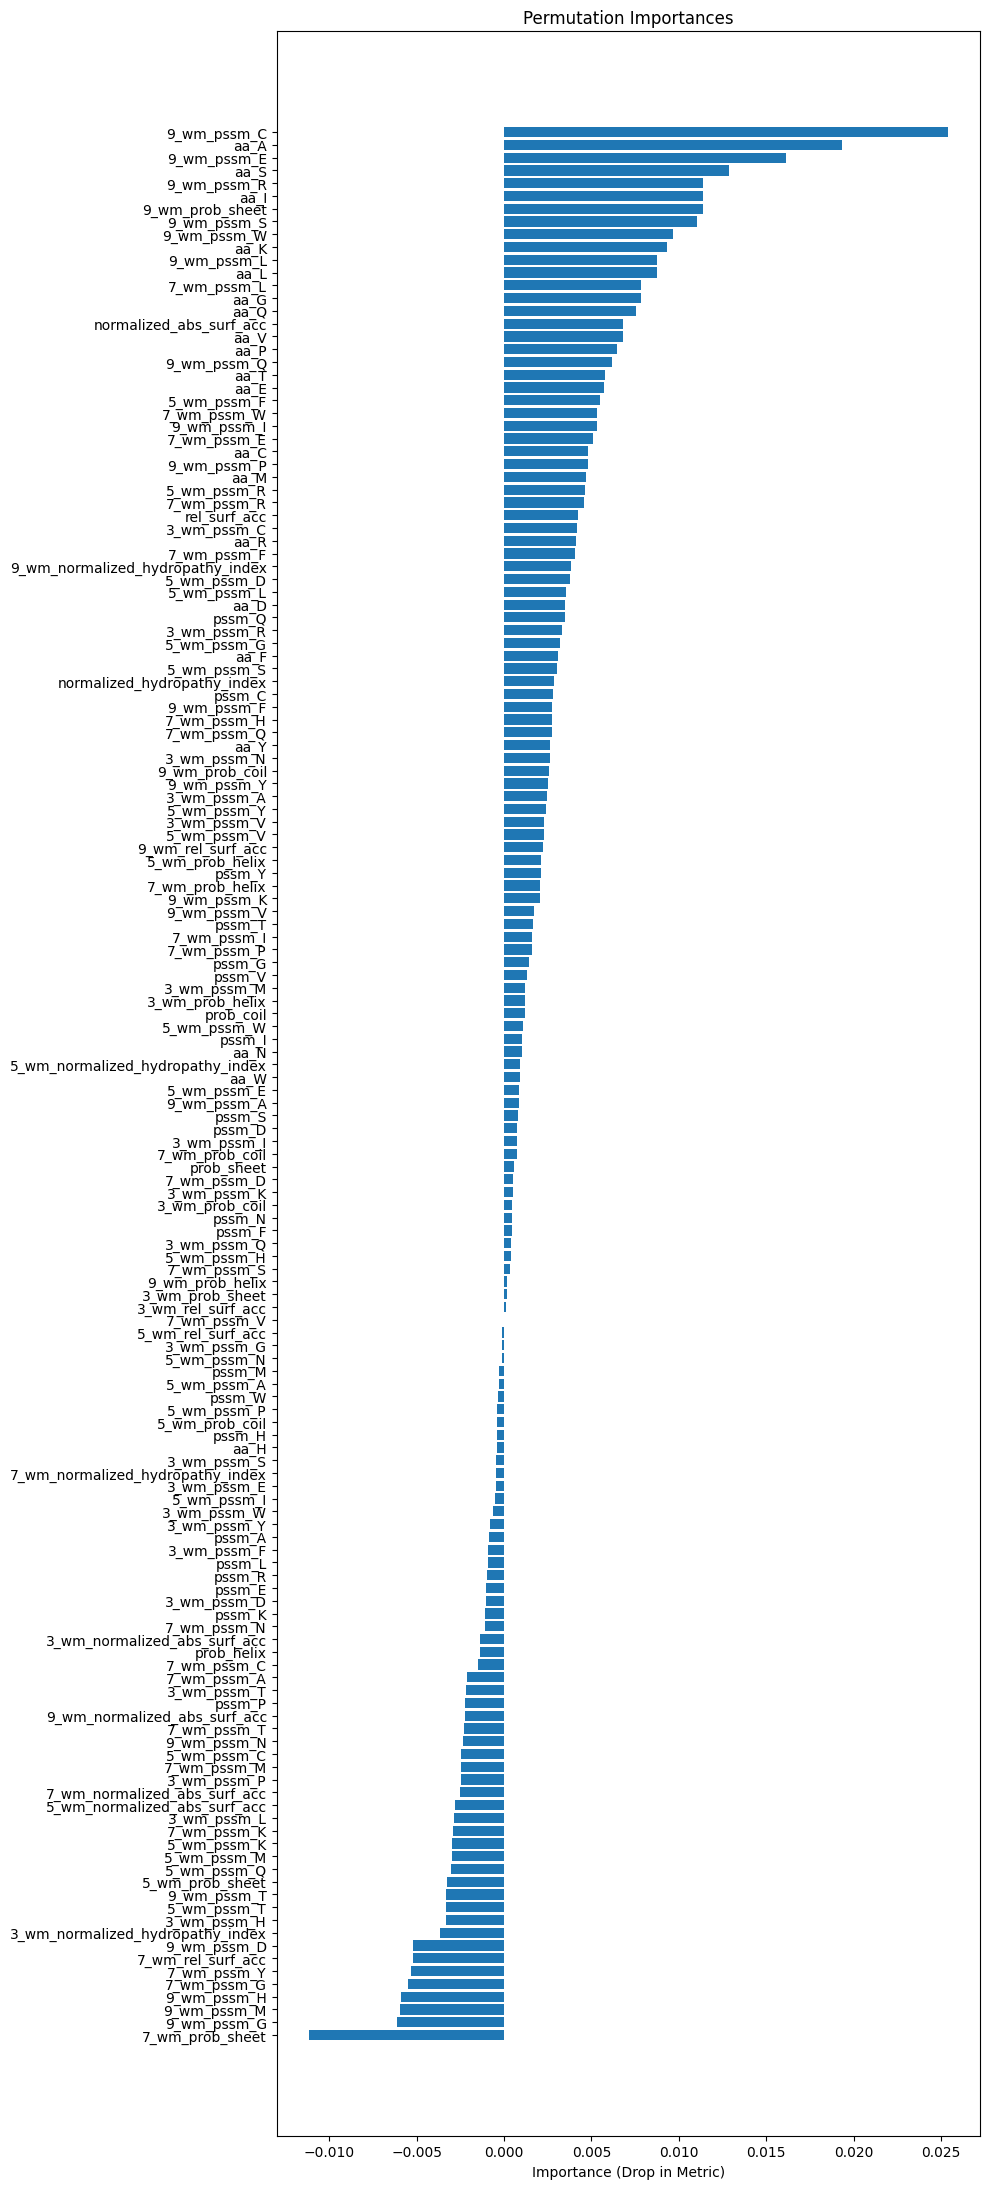

In [61]:
plot_permutation_importances(importances2, feature_names_without_length)